In [12]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pybedtools import BedTool  # For efficient genomic interval operations
from matplotlib.colors import ListedColormap


In [13]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    return tuple(int(value[i:i+2], 16)/255 for i in (0, 2, 4))

In [14]:
color1 = hex_to_rgb("#ffffff")  # white
color2 = hex_to_rgb("#79c064")  # green

# Create a gradient with 256 steps
gradient = np.linspace(0, 1, 256)
colors = [(
    color1[0] + (color2[0]-color1[0])*x,
    color1[1] + (color2[1]-color1[1])*x,
    color1[2] + (color2[2]-color1[2])*x
) for x in gradient]

wg_cmap = ListedColormap(colors, name="white_green")

In [15]:
# Define the three colors in HEX
colors_hex = ['#6b8ae0', '#ffffff', '#da6290']

# Convert all colors to RGB
colors_rgb = [hex_to_rgb(c) for c in colors_hex]

# Create gradient with 256 steps
n_bins = 256  # Number of discrete colors in the colormap
cmap_name = 'blue_white_pink'

# Create the colormap
gradient = np.linspace(0, 1, n_bins)
colors = []
for x in gradient:
    if x < 0.5:  # First half: blue to white
        t = x * 2  # Scale to 0-1
        r = colors_rgb[0][0] + (colors_rgb[1][0] - colors_rgb[0][0]) * t
        g = colors_rgb[0][1] + (colors_rgb[1][1] - colors_rgb[0][1]) * t
        b = colors_rgb[0][2] + (colors_rgb[1][2] - colors_rgb[0][2]) * t
    else:  # Second half: white to pink
        t = (x - 0.5) * 2  # Scale to 0-1
        r = colors_rgb[1][0] + (colors_rgb[2][0] - colors_rgb[1][0]) * t
        g = colors_rgb[1][1] + (colors_rgb[2][1] - colors_rgb[1][1]) * t
        b = colors_rgb[1][2] + (colors_rgb[2][2] - colors_rgb[1][2]) * t
    colors.append((r, g, b))

bwp_cmap = ListedColormap(colors, name=cmap_name)

In [2]:
# Function to extract chromosome, start, and end from the insertion/TEIcoord string
def extract_coords(coord_str):
    match = re.match(r'([^:]+):(\d+)\.\.(\d+)', coord_str)
    if match:
        chr_name = match.group(1)
        start = int(match.group(2))
        end = int(match.group(3))
        return chr_name, start, end
    return None, None, None

In [3]:
tei_ori = pd.read_csv('TEI_S1_orientation.tsv', sep='\t')

match_dfs = {'12-1': pd.DataFrame(tei_ori[tei_ori['sample']=='SQK-NBD114-96_barcode01']), 
            '1-1': pd.DataFrame(tei_ori[tei_ori['sample']=='SQK-NBD114-96_barcode19']),
            '3-6': pd.DataFrame(tei_ori[tei_ori['sample']=='SQK-NBD114-96_barcode20']),
            '7-5': pd.DataFrame(tei_ori[tei_ori['sample']=='SQK-NBD114-96_barcode21']),
            '13-1': pd.DataFrame(tei_ori[tei_ori['sample']=='SQK-NBD114-96_barcode22']),
            '14-2': pd.DataFrame(tei_ori[tei_ori['sample']=='SQK-NBD114-96_barcode23'])
            }

tei_bins = {}
for key in ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']:
    for context in ['CG', 'CHG', 'CHH']:
        tei_bins[f'{key}_{context}'] = pd.read_csv(f'TEI_meth_bins/TEI_binned_methylation_{key}_{context}.csv')

tei_flanks = {}
for key in ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']:
    for context in ['CG', 'CHG', 'CHH']:
        tei_flanks[f'{key}_{context}'] = pd.read_csv(f'TEI_flanks/{key}_{context}_flanking_methylation_2kb.csv')

onsen_bins = {}
for key in ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']:
    for context in ['CG', 'CHG', 'CHH']:
        onsen_bins[f'{key}_{context}'] = pd.read_csv(f'ONSENs_meth_bins/ONSEN_binned_methylation_{key}_{context}.csv')

onsen_flanks = {}
for key in ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']:
    for context in ['CG', 'CHG', 'CHH']:
        onsen_flanks[f'{key}_{context}'] = pd.read_csv(f'ONSENs_flanks/ONSEN_flanking_methylation_{key}_{context}.csv').groupby('ONSEN').mean().reset_index()

results_col_dict = {}
for key in ['12-1_Col-0', '1-1_Col-0', '3-6_Col-0', '7-5_Col-0', '13-1_Col-0', '14-2_Col-0']:
    for context in ['CG', 'CHG', 'CHH']:
        results_col_dict[f'{key}_{context}'] = pd.read_csv(f'TEI_flanks/{key}_{context}_flanking_methylation_2kb.csv')

evd_bins = {}
for key in ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']:
    for context in ['CG', 'CHG', 'CHH']:
        evd_bins[f'{key}_{context}'] = pd.read_csv(f'EVD_meth_bins/EVD_binned_methylation_{key}_{context}.csv')

evd_flanks = {}
for key in ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']:
    for context in ['CG', 'CHG', 'CHH']:
        evd_flanks[f'{key}_{context}'] = pd.read_csv(f'EVDs_flanks/EVD_flanking_methylation_{key}_{context}.csv')

In [4]:
matched_dfs = {}

# Define a tolerance for start/end positions (e.g., ±5 bp)
TOLERANCE = 30
for key in ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']:
    df2 = match_dfs[key]

    # Add extracted coordinates to df2
    df2[['chr', 'start', 'end']] = df2['TEIcoord'].apply(extract_coords).apply(pd.Series)

    for context in ['CG', 'CHG', 'CHH']:
        df1 = tei_flanks[f'{key}_{context}'] 
        
        # Add extracted coordinates to df1
        df1[['chr', 'start', 'end']] = df1['insertion'].apply(extract_coords).apply(pd.Series)


        # Merge df1 and df2 based on fuzzy matching of coordinates
        merged_df = pd.merge(
            df1,
            df2,
            on='chr',  # Match by chromosome
            suffixes=('_df1', '_df2')
        )

        # Filter rows where start and end positions are within the tolerance
        merged_df = merged_df[
            (abs(merged_df['start_df1'] - merged_df['start_df2']) <= TOLERANCE) &
            (abs(merged_df['end_df1'] - merged_df['end_df2']) <= TOLERANCE)
        ]

        # Drop unnecessary columns
        merged_df = merged_df.drop(columns=['chr', 'start_df1', 'end_df1', 'start_df2', 'end_df2'])

        # Reorder columns for clarity
        merged_df = merged_df[['insertion', 'TEIcoord', 'sample', 'zygoticity', 'orientaion_TEI', 'orientation_gene', 'consistency', 'origin'] + 
                        [col for col in merged_df.columns if col.startswith('bin_')]]
        matched_dfs[f'{key}_{context}'] = merged_df

        

In [5]:
results_diff_dict = {}


for df_1, df_2, df_name in zip(matched_dfs.values(), results_col_dict.values(), matched_dfs.keys()):

    df_2 = df_2[df_2['insertion'].isin(df_1['insertion'])].sort_values(by='insertion').reset_index(drop=True)
    df_1 = df_1.sort_values(by='insertion').reset_index(drop=True)

    ins = df_1['insertion'].values
    zygo = df_1['zygoticity'].values
    ori = df_1['orientaion_TEI'].values
    orig = df_1['orientation_gene'].values
    cons = df_1['consistency'].values
    origin = df_1['origin']

    df_1 = df_1.iloc[:, 7:]
    df_2 = df_2.iloc[:, :80]

    df_diff = df_1 - df_2
    df_diff['insertion'] = ins
    df_diff['zygoticity'] = zygo
    df_diff['orientation_TEI'] = ori
    df_diff['orientation_gene'] = orig
    df_diff['consistency'] = cons
    df_diff['origin'] = origin

    results_diff_dict[df_name] = df_diff
    #print('OK')

In [6]:
# Define the centromere regions for each chromosome (without North/South distinction)
centromere_regions = {
    'NC_003070.9': {  # Chromosome 1
        'Arm': [(1, 11420000), (18270001, 30427671)],
        'Pericentromere': [(11420001, 13920000), (15970001, 18270000)],
        'Centromere': [(13920001, 15970000)]
    },
    'NC_003071.7': {  # Chromosome 2
        'Arm': [(1, 910000), (7320001, 19698289)],
        'Pericentromere': [(910001, 2950000), (4750001, 7320000)],
        'Centromere': [(2950001, 4750000)]
    },
    'NC_003074.8': {  # Chromosome 3
        'Arm': [(1, 10390000), (16730001, 23459830)],
        'Pericentromere': [(10390001, 12680000), (14750001, 16730000)],
        'Centromere': [(12680001, 14750000)]
    },
    'NC_003075.7': {  # Chromosome 4
        'Arm': [(1, 1070000), (6630001, 18585056)],
        'Pericentromere': [(1070001, 3390000), (4820001, 6630000)],
        'Centromere': [(3390001, 4820000)]
    },
    'NC_003076.8': {  # Chromosome 5
        'Arm': [(1, 8890000), (15550001, 26975502)],
        'Pericentromere': [(8890001, 10950000), (13240001, 15550000)],
        'Centromere': [(10950001, 13240000)]
    }
}

# Function to classify the insertion position relative to the centromere
def classify_insertion_position(chr_name, position):
    if chr_name not in centromere_regions:
        return 'Unknown'  # Handle unknown chromosomes
    
    regions = centromere_regions[chr_name]
    for region, ranges in regions.items():
        for start, end in ranges:
            if start <= position <= end:
                return region
    return 'Unknown'  # Handle positions outside defined regions


In [8]:

# Load the gene annotation file and retain only 'gene' features
gene_annotation = pd.read_csv(
    '../Araport11_GTF_genes_transposons.current.fixed.sorted.gff',
    sep='\t',
    comment='#',
    header=None,
    names=[
        'gene_chr', 'source', 'type', 'gene_start', 'gene_end', 'score', 'gene_strand', 'phase', 'attributes'
    ]
)

gene_annotation = gene_annotation[gene_annotation['type']=='mRNA']

# Extract chromosome, start, end, strand, and gene name from the gene annotation
gene_annotation['gene_name'] = gene_annotation['attributes'].str.extract(r'ID=([^;]+)')

gene_annotation = gene_annotation[['gene_chr', 'gene_start', 'gene_end', 'gene_strand', 'gene_name']]

# Convert gene annotation to BedTool for efficient intersection
gene_bed = BedTool.from_dataframe(gene_annotation)

# Function to extract chromosome, start, and end from the 'insertion' column
def extract_coords(coord_str):
    match = re.match(r'([^:]+):(\d+)\.\.(\d+)', coord_str)
    if match:
        chr_name = match.group(1)
        start = int(match.group(2))
        end = int(match.group(3))
        return chr_name, start, end
    return None, None, None

# Initialize a dictionary to store updated DataFrames
results_diff_dict_feat = {}

# Iterate through each DataFrame in results_diff_dict
for key, df_diff in results_diff_dict.items():
    # Calculate mean_left, mean_right, and left_to_right_diff
    df_diff['mean_left'] = df_diff[[f'bin_{i}' for i in range(1, 41)]].mean(axis=1)
    df_diff['mean_right'] = df_diff[[f'bin_{i}' for i in range(41, 81)]].mean(axis=1)
    df_diff['left_to_right_diff'] = df_diff['mean_left'] - df_diff['mean_right']
    df_diff['dominance'] = np.where(df_diff['left_to_right_diff'] > 0, 'left', 'right')
    
    # Extract chromosome and position from the 'insertion' column
    df_diff[['chr', 'start', 'end']] = df_diff['insertion'].apply(extract_coords).apply(pd.Series)
    
    # Classify the insertion position relative to the centromere
    df_diff['cen_pos'] = df_diff.apply(
        lambda row: classify_insertion_position(row['chr'], row['start']), axis=1
    )
    
    # Convert insertions to BedTool for efficient intersection
    insertions_bed = BedTool.from_dataframe(df_diff[['chr', 'start', 'end']])
    
    # Intersect insertions with gene annotations
    intersections = insertions_bed.intersect(gene_bed, wa=True, wb=True)
    
    # Convert intersections to DataFrame
    intersections_df = intersections.to_dataframe(
        names=['chr', 'start', 'end', 'gene_chr', 'gene_start', 'gene_end', 'gene_strand', 'gene_name']
    )
    
    # Add gene_name to intersections_df by merging with gene_annotation
    intersections_df = intersections_df.merge(
        gene_annotation,
        how='left',
        left_on=['gene_chr', 'gene_start', 'gene_end', 'gene_strand', 'gene_name'],
        right_on=['gene_chr', 'gene_start', 'gene_end', 'gene_strand', 'gene_name']
    )
    
    # Check if intersections_df is empty
    if not intersections_df.empty:
        # Merge intersections with the original DataFrame
        df_diff = df_diff.merge(
            intersections_df[['chr', 'start', 'end', 'gene_name', 'gene_strand', 'gene_start', 'gene_end']],
            how='left',
            left_on=['chr', 'start', 'end'],
            right_on=['chr', 'start', 'end']
        )
    else:
        # If no intersections, add empty columns
        df_diff['gene_name'] = np.nan

    
    # Add 'genic' column (True if the insertion intersects with a gene)
    # df_diff = df_diff.fillna('.')
    df_diff['genic'] = ~df_diff['gene_name'].isna()
    # df_diff.loc[df_diff['gene_name'].isna()]['genic'] = False


    
    # Add 'genic_position' column
    df_diff['genic_position'] = np.where(
        df_diff['genic'],  # Only calculate for genic insertions
        np.where(
            df_diff['gene_strand'] == '-',
            (df_diff['gene_end'] - (df_diff['start']+ df_diff['end'])/2) / (df_diff['gene_end'] - df_diff['gene_start']),
            ((df_diff['start']+ df_diff['end'])/2 - df_diff['gene_start']) / (df_diff['gene_end'] - df_diff['gene_start'])
        ),
        np.nan  # Set to NaN for non-genic insertions
    )
    
    # Drop temporary columns
    df_diff.drop(columns=['chr', 'start', 'end'], inplace=True)
    df_diff.drop_duplicates('insertion', inplace=True)
    df_diff = df_diff[[f'bin_{n}' for n in range(1, 81)] + df_diff.columns.to_list()[80:]]
    
    # Store the updated DataFrame in the results_diff_dict_feat dictionary
    results_diff_dict_feat[key] = df_diff

In [9]:
tei_ori = pd.concat([df for df in results_diff_dict_feat.values()])
sss = []
for key in ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']:
    for context in ['CG', 'CHG', 'CHH']:
        for i in range(len(results_diff_dict_feat[f'{key}_{context}'])):
            sss.append(f'{key}_{context}')
tei_ori['sample'] = sss

In [10]:
lookup = tei_ori.iloc[:, 80:]
lookup = lookup[lookup['sample'].str.endswith('CHH')]

In [72]:
lookup.to_csv('tei_features.csv', index=False)

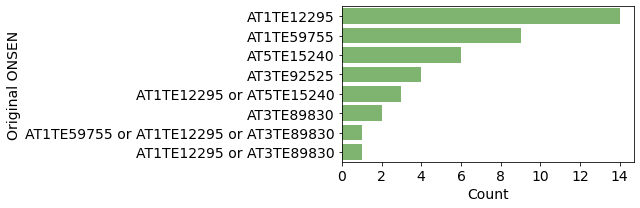

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))
sns.countplot(y='origin', data=lookup, 
                color='#79c064' , order=lookup['origin'].value_counts().index, ax=axes)
axes.set_ylabel('Original ONSEN', fontsize=14)
axes.set_xlabel('Count', fontsize=14)
axes.set_xticks(range(0, 16, 2))  # Positions for -1000bp, TEI, +1000bp (aligned to edges)
axes.set_xticklabels(range(0, 16, 2), fontsize=14, rotation=0)
plt.tick_params(axis='both', which='both', labelsize=14)  # Hide tick marks

plt.tight_layout()
plt.savefig('plots/TEIs_origin_stats.svg', bbox_inches='tight', dpi=300)


# TE metaplots

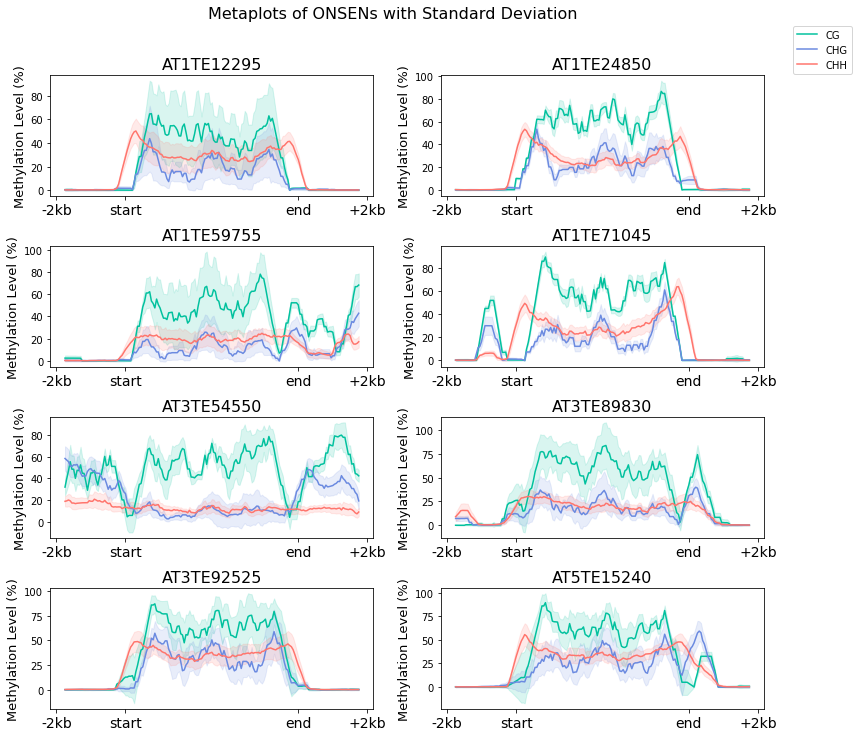

In [43]:
# Define the contexts
contexts = ['CG', 'CHG', 'CHH']
samples_tei = ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']
samples_onsen = ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']

# Extract ONSEN names
onsen_names = onsen_bins[f'{samples_onsen[0]}_{contexts[0]}']['ONSEN'].unique()

# Initialize dictionaries to store combined data
combined_onsen = {context: [] for context in contexts}
combined_tei = {context: [] for context in contexts}

# Combine ONSEN data (bins + flanks)
for context in contexts:
    for key in samples_onsen:
        # Load ONSEN bins and flanks data
        bins = onsen_bins[f'{key}_{context}']
        flanks = onsen_flanks[f'{key}_{context}'].iloc[:, :81]
        
        # Rename columns to avoid conflicts
        flanks.columns = ['ONSEN']+[f'flank_{i}' for i in range(1, 81)]  # Rename flank columns
        bins.columns = ['ONSEN']+[f'bin_{i}' for i in range(1, len(bins.columns))]  # Rename bin columns
        
        # Combine bins and flanks into a single DataFrame
        combined = pd.merge(flanks, bins, on='ONSEN')
        combined = combined[['ONSEN']+[f'flank_{i}' for i in range(1, 41)]+ [f'bin_{i}' for i in range(1, len(bins.columns))]+ [f'flank_{i}' for i in range(41, 81)]]
        combined_onsen[context].append(combined)
    
    combined_onsen[context] = pd.concat(combined_onsen[context])

# Combine TEI data (bins + flanks)
for context in contexts:
    for key in samples_tei:
        bins = tei_bins[f'{key}_{context}']
        flanks = tei_flanks[f'{key}_{context}'].iloc[:, :81]
        
        flanks.columns = [f'flank_{i}' for i in range(1, 81)]+['TEI']
        bins.columns = ['TEI']+[f'bin_{i}' for i in range(1, len(bins.columns))]
        
        combined = pd.merge(flanks, bins, on='TEI')
        combined = pd.merge(combined, tei_ori[tei_ori['sample'] == f'{key}_{context}'][['insertion', 'origin']], right_on='insertion', left_on='TEI') 
        combined = combined[['origin']+[f'flank_{i}' for i in range(1, 41)]+ [f'bin_{i}' for i in range(1, len(bins.columns))]+ [f'flank_{i}' for i in range(41, 81)]]
        
        combined_tei[context].append(combined)
    
    combined_tei[context] = pd.concat(combined_tei[context])

# Calculate mean and std
mean_onsen = {
    context: combined_onsen[context].groupby('ONSEN').mean().reset_index()
    for context in contexts
}
std_onsen = {
    context: combined_onsen[context].groupby('ONSEN').std().reset_index()
    for context in contexts
}

mean_tei = {
    context: combined_tei[context].groupby('origin').mean().reset_index()
    for context in contexts
}
std_tei = {
    context: combined_tei[context].groupby('origin').std().reset_index()
    for context in contexts
}

# Smooth the data
window_size = 10
smoothed_mean_onsen = {
    context: mean_onsen[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}
smoothed_std_onsen = {
    context: std_onsen[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}

smoothed_mean_tei = {
    context: mean_tei[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}
smoothed_std_tei = {
    context: std_tei[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}

# Define colors and alpha for std
context_colors = {'CG': '#01c19e', 'CHG': '#6b8ae0', 'CHH': '#ff756d'}
alpha = 0.15  # Transparency for std shading

# Create the metaplots
fig, axes = plt.subplots(nrows=int(len(onsen_names) / 2), ncols=2, figsize=(11, 10))
axes = axes.flatten()
fig.suptitle('Metaplots of ONSENs with Standard Deviation', fontsize=16, y=1.02)

# Create legend handles
handles, labels = [], []

# Plot ONSEN and TEI metaplots for each ONSEN
for i, onsen_name in enumerate(onsen_names):
    ax = axes[i]
    
    # Plot ONSEN methylation with std
    for context in contexts:
        # Get mean and std
        mean = smoothed_mean_onsen[context][mean_onsen[context]['ONSEN'] == onsen_name].values.flatten()
        std = smoothed_std_onsen[context][std_onsen[context]['ONSEN'] == onsen_name].values.flatten()
        
        # Plot mean line
        line, = ax.plot(mean, label=f'{context}', color=context_colors[context], linestyle='-')
        
        # Plot std shading
        ax.fill_between(range(len(mean)), mean - std, mean + std, 
                        color=context_colors[context], alpha=alpha)
        
        if i == 0:  # Add to legend only once
            handles.append(line)
            labels.append(f'{context}')
    
    # Customize the plot
    ax.set_title(f'{onsen_name}', fontsize=16)
    ax.set_ylabel('Methylation Level (%)', fontsize=13)
    ax.grid(False)
    ax.set_xticks([0, 40, 140, 180])
    ax.set_xticklabels(['-2kb', 'start', 'end', '+2kb'], fontsize=14)

# Add a single legend for the whole figure
fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.savefig('plots/metaplots_onsen_with_std.svg', bbox_inches='tight', dpi=300)

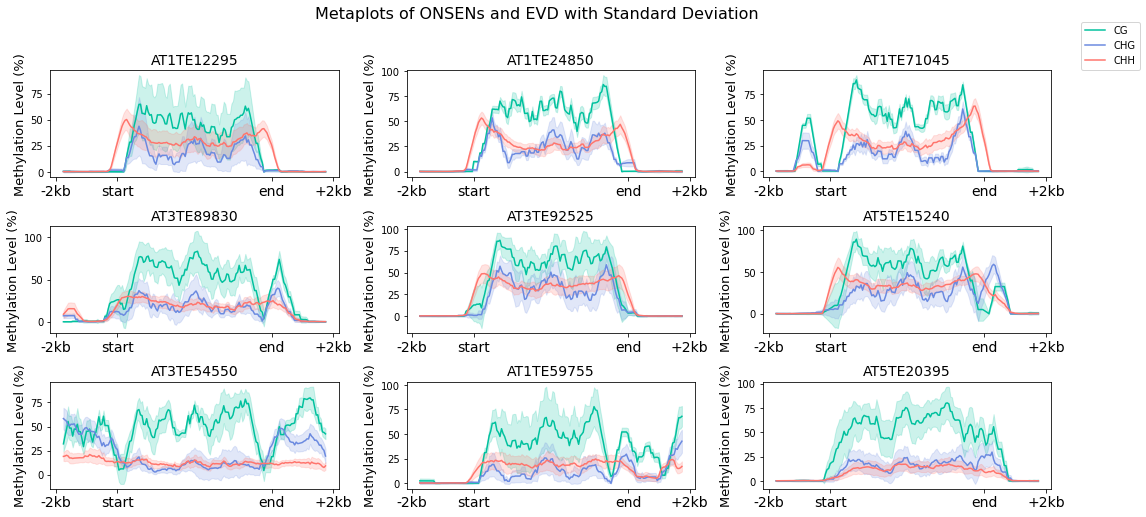

In [44]:
# Define the contexts
contexts = ['CG', 'CHG', 'CHH']
samples_tei = ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']
samples_onsen = ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']

# Extract ONSEN names
onsen_names = onsen_bins[f'{samples_onsen[0]}_{contexts[0]}']['ONSEN'].unique()

# Add EVD name to the list
all_names = list(onsen_names) + ['AT5TE20395']  # EVD added at the end initially

# Reorder the names so the last row contains AT3TE54550, AT1TE59755, and AT5TE20395 (EVD)
# First get the 6 names that aren't these three
other_names = [name for name in all_names if name not in ['AT3TE54550', 'AT1TE59755', 'AT5TE20395']]
# Then create the final order
ordered_names = other_names[:6] + ['AT3TE54550', 'AT1TE59755', 'AT5TE20395']

# Initialize dictionaries to store combined data
combined_onsen = {context: [] for context in contexts}
combined_tei = {context: [] for context in contexts}
combined_evd = {context: [] for context in contexts}  # For EVD data

# Combine ONSEN data (bins + flanks)
for context in contexts:
    for key in samples_onsen:
        # Load ONSEN bins and flanks data
        bins = onsen_bins[f'{key}_{context}']
        flanks = onsen_flanks[f'{key}_{context}'].iloc[:, :81]
        
        # Rename columns to avoid conflicts
        flanks.columns = ['ONSEN']+[f'flank_{i}' for i in range(1, 81)]
        bins.columns = ['ONSEN']+[f'bin_{i}' for i in range(1, len(bins.columns))]
        
        # Combine bins and flanks
        combined = pd.merge(flanks, bins, on='ONSEN')
        combined = combined[['ONSEN']+[f'flank_{i}' for i in range(1, 41)]+ [f'bin_{i}' for i in range(1, len(bins.columns))]+ [f'flank_{i}' for i in range(41, 81)]]
        combined_onsen[context].append(combined)
    
    combined_onsen[context] = pd.concat(combined_onsen[context])

# Combine EVD data (same structure as ONSEN)
for context in contexts:
    for key in samples_onsen:
        # Load EVD bins and flanks data
        bins = evd_bins[f'{key}_{context}']
        flanks = evd_flanks[f'{key}_{context}'].iloc[:, :81]
        
        # Rename columns
        flanks.columns = ['EVD']+[f'flank_{i}' for i in range(1, 81)]
        bins.columns = ['EVD']+[f'bin_{i}' for i in range(1, len(bins.columns))]
        
        # Combine bins and flanks
        combined = pd.merge(flanks, bins, on='EVD')
        combined = combined[['EVD']+[f'flank_{i}' for i in range(1, 41)]+ [f'bin_{i}' for i in range(1, len(bins.columns))]+ [f'flank_{i}' for i in range(41, 81)]]
        combined_evd[context].append(combined)
    
    combined_evd[context] = pd.concat(combined_evd[context])

# Combine TEI data (bins + flanks)
for context in contexts:
    for key in samples_tei:
        bins = tei_bins[f'{key}_{context}']
        flanks = tei_flanks[f'{key}_{context}'].iloc[:, :81]
        
        flanks.columns = [f'flank_{i}' for i in range(1, 81)]+['TEI']
        bins.columns = ['TEI']+[f'bin_{i}' for i in range(1, len(bins.columns))]
        
        combined = pd.merge(flanks, bins, on='TEI')
        combined = pd.merge(combined, tei_ori[tei_ori['sample'] == f'{key}_{context}'][['insertion', 'origin']], right_on='insertion', left_on='TEI') 
        combined = combined[['origin']+[f'flank_{i}' for i in range(1, 41)]+ [f'bin_{i}' for i in range(1, len(bins.columns))]+ [f'flank_{i}' for i in range(41, 81)]]
        
        combined_tei[context].append(combined)
    
    combined_tei[context] = pd.concat(combined_tei[context])

# Calculate mean and std for ONSENs
mean_onsen = {
    context: combined_onsen[context].groupby('ONSEN').mean().reset_index()
    for context in contexts
}
std_onsen = {
    context: combined_onsen[context].groupby('ONSEN').std().reset_index()
    for context in contexts
}

# Calculate mean and std for EVD
mean_evd = {
    context: combined_evd[context].groupby('EVD').mean().reset_index()
    for context in contexts
}
std_evd = {
    context: combined_evd[context].groupby('EVD').std().reset_index()
    for context in contexts
}

# Smooth the data
window_size = 10
smoothed_mean_onsen = {
    context: mean_onsen[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}
smoothed_std_onsen = {
    context: std_onsen[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}

smoothed_mean_evd = {
    context: mean_evd[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}
smoothed_std_evd = {
    context: std_evd[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}

# Define colors and alpha for std
context_colors = {'CG': '#01c19e', 'CHG': '#6b8ae0', 'CHH': '#ff756d'}
alpha = 0.2

# Create the metaplots - now 3 rows x 3 columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7))
axes = axes.flatten()
fig.suptitle('Metaplots of ONSENs and EVD with Standard Deviation', fontsize=16, y=1.02)

# Create legend handles
handles, labels = [], []

# Plot all elements in the specified order
for i, name in enumerate(ordered_names):
    ax = axes[i]
    
    # Determine if this is an ONSEN or EVD
    if name in onsen_names:
        # Plot ONSEN methylation with std
        for context in contexts:
            mean = smoothed_mean_onsen[context][mean_onsen[context]['ONSEN'] == name].values.flatten()
            std = smoothed_std_onsen[context][std_onsen[context]['ONSEN'] == name].values.flatten()
            
            line, = ax.plot(mean, label=f'{context}', color=context_colors[context], linestyle='-')
            ax.fill_between(range(len(mean)), mean - std, mean + std, 
                          color=context_colors[context], alpha=alpha)
            
            if i == 0:  # Add to legend only once
                handles.append(line)
                labels.append(f'{context}')
    else:
        # Plot EVD methylation with std
        for context in contexts:
            mean = smoothed_mean_evd[context][mean_evd[context]['EVD'] == name].values.flatten()
            std = smoothed_std_evd[context][std_evd[context]['EVD'] == name].values.flatten()
            
            line, = ax.plot(mean, label=f'{context}', color=context_colors[context], linestyle='-')  # Dashed for EVD
            ax.fill_between(range(len(mean)), mean - std, mean + std, 
                          color=context_colors[context], alpha=alpha)
            
            if i == 0:  # Add to legend only once
                handles.append(line)
                labels.append(f'{context} (EVD)')
    
    # Customize the plot
    ax.set_title(f'{name}', fontsize=14)
    ax.set_ylabel('Methylation Level (%)', fontsize=13)
    ax.grid(False)
    ax.set_xticks([0, 40, 140, 180])
    ax.set_xticklabels(['-2kb', 'start', 'end', '+2kb'], fontsize=14)

# Remove the 10th subplot if it exists (we have 9 plots)
if len(axes) > 9:
    for ax in axes[9:]:
        ax.remove()

# Add a single legend for the whole figure
fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.savefig('plots/metaplots_onsen_evd_with_std.svg', bbox_inches='tight', dpi=300)

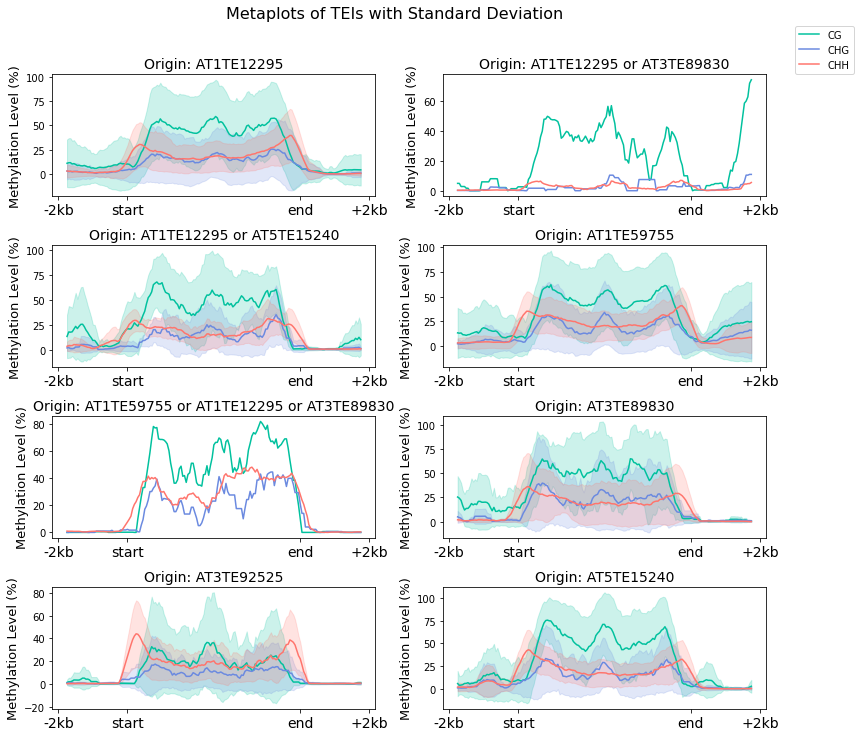

In [47]:
# Define the contexts
contexts = ['CG', 'CHG', 'CHH']
samples_tei = ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']
samples_onsen = ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']

# Extract ONSEN names
onsen_names = onsen_bins[f'{samples_onsen[0]}_{contexts[0]}']['ONSEN'].unique()

# Initialize dictionaries to store combined data
combined_onsen = {context: [] for context in contexts}
combined_tei = {context: [] for context in contexts}



# Combine TEI data (bins + flanks)
for context in contexts:
    for key in samples_tei:
        bins = tei_bins[f'{key}_{context}']
        flanks = tei_flanks[f'{key}_{context}'].iloc[:, :81]
        
        flanks.columns = [f'flank_{i}' for i in range(1, 81)]+['TEI']
        bins.columns = ['TEI']+[f'bin_{i}' for i in range(1, len(bins.columns))]
        
        combined = pd.merge(flanks, bins, on='TEI')
        combined = pd.merge(combined, tei_ori[tei_ori['sample'] == f'{key}_{context}'][['insertion', 'origin']], right_on='insertion', left_on='TEI') 
        combined = combined[['origin']+[f'flank_{i}' for i in range(1, 41)]+ [f'bin_{i}' for i in range(1, len(bins.columns))]+ [f'flank_{i}' for i in range(41, 81)]]
        
        combined_tei[context].append(combined)
    
    combined_tei[context] = pd.concat(combined_tei[context])



mean_tei = {
    context: combined_tei[context].groupby('origin').mean().reset_index()
    for context in contexts
}
std_tei = {
    context: combined_tei[context].groupby('origin').std().reset_index()
    for context in contexts
}

# Smooth the data
window_size = 10


smoothed_mean_tei = {
    context: mean_tei[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}
smoothed_std_tei = {
    context: std_tei[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}

# Define colors and alpha for std
context_colors = {'CG': '#01c19e', 'CHG': '#6b8ae0', 'CHH': '#ff756d'}
alpha = 0.2  # Transparency for std shading

# Create the metaplots
fig, axes = plt.subplots(nrows=int(len(mean_tei[contexts[0]]['origin'].unique()) / 2), ncols=2, figsize=(11, 10))
axes = axes.flatten()
fig.suptitle('Metaplots of TEIs with Standard Deviation', fontsize=16, y=1.02)

# Create legend handles
handles, labels = [], []

# Plot ONSEN and TEI metaplots for each ONSEN
for i, onsen_name in enumerate(mean_tei[contexts[0]]['origin'].unique()):
    ax = axes[i]
    
    #Plot TEI methylation with std (if TEIs exist)
    if onsen_name in mean_tei[contexts[0]]['origin'].unique():
        for context in contexts:
            # Get mean and std
            mean = smoothed_mean_tei[context][mean_tei[context]['origin'] == onsen_name].values.flatten()
            std = smoothed_std_tei[context][std_tei[context]['origin'] == onsen_name].values.flatten()
            
            # Plot mean line
            line, = ax.plot(mean, label=f'{context}', color=context_colors[context], linestyle='-')
            
            # Plot std shading
            ax.fill_between(range(len(mean)), mean - std, mean + std, 
                            color=context_colors[context], alpha=alpha)
            
            if i == 0:  # Add to legend only once
                handles.append(line)
                labels.append(f'{context}')
    
    # Customize the plot
    ax.set_title(f'Origin: {onsen_name}', fontsize=14)
    ax.set_ylabel('Methylation Level (%)', fontsize=13)
    ax.grid(False)
    ax.set_xticks([0, 40, 140, 180])
    ax.set_xticklabels(['-2kb', 'start', 'end', '+2kb'], fontsize=14)

# Add a single legend for the whole figure
fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.savefig('plots/metaplots_tei_with_std.svg', bbox_inches='tight', dpi=300)


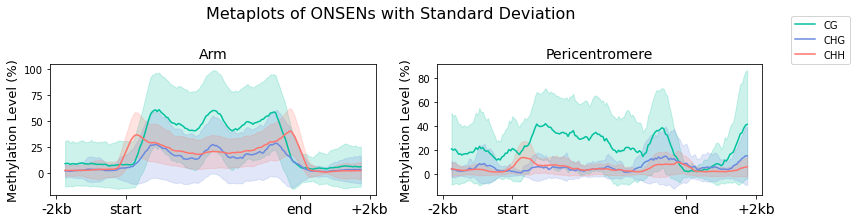

In [48]:
# Define the contexts
contexts = ['CG', 'CHG', 'CHH']
samples_tei = ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']
samples_onsen = ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']

# Extract ONSEN names
# onsen_names = onsen_bins[f'{samples_onsen[0]}_{contexts[0]}']['ONSEN'].unique()

# Initialize dictionaries to store combined data
combined_onsen = {context: [] for context in contexts}
combined_tei = {context: [] for context in contexts}

# Combine ONSEN data (bins + flanks)

# Combine TEI data (bins + flanks)
for context in contexts:
    for key in samples_tei:
        bins = tei_bins[f'{key}_{context}']
        flanks = tei_flanks[f'{key}_{context}'].iloc[:, :81]
        
        flanks.columns = [f'flank_{i}' for i in range(1, 81)]+['TEI']
        bins.columns = ['TEI']+[f'bin_{i}' for i in range(1, len(bins.columns))]

        combined = pd.merge(flanks, bins, on='TEI')
        combined = pd.merge(combined, tei_ori[tei_ori['sample'] == f'{key}_{context}'][['insertion', 'cen_pos']], right_on='insertion', left_on='TEI') 
        combined = combined[['cen_pos']+[f'flank_{i}' for i in range(1, 41)]+ [f'bin_{i}' for i in range(1, len(bins.columns))]+ [f'flank_{i}' for i in range(41, 81)]]
        
        combined_tei[context].append(combined)
    
    combined_tei[context] = pd.concat(combined_tei[context])


mean_tei = {
    context: combined_tei[context].groupby('cen_pos').mean().reset_index()
    for context in contexts
}
std_tei = {
    context: combined_tei[context].groupby('cen_pos').std().reset_index()
    for context in contexts
}

# Smooth the data

smoothed_mean_tei = {
    context: mean_tei[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}
smoothed_std_tei = {
    context: std_tei[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}

# Define colors and alpha for std
context_colors = {'CG': '#01c19e', 'CHG': '#6b8ae0', 'CHH': '#ff756d'}
alpha = 0.2  # Transparency for std shading

# Create the metaplots
fig, axes = plt.subplots(nrows=int(len(mean_tei[contexts[0]]['cen_pos'].unique()) / 2), ncols=2, figsize=(11, 3))
axes = axes.flatten()
fig.suptitle('Metaplots of ONSENs with Standard Deviation', fontsize=16, y=1.02)

# Create legend handles
handles, labels = [], []

# Plot ONSEN and TEI metaplots for each ONSEN
for i, onsen_name in enumerate(mean_tei[contexts[0]]['cen_pos'].unique()):
    ax = axes[i]
    
    #Plot TEI methylation with std (if TEIs exist)
    if onsen_name in mean_tei[contexts[0]]['cen_pos'].unique():
        for context in contexts:
            # Get mean and std
            mean = smoothed_mean_tei[context][mean_tei[context]['cen_pos'] == onsen_name].values.flatten()
            std = smoothed_std_tei[context][std_tei[context]['cen_pos'] == onsen_name].values.flatten()
            
            # Plot mean line
            line, = ax.plot(mean, label=f'TEI {context}', color=context_colors[context], linestyle='-')
            
            # Plot std shading
            ax.fill_between(range(len(mean)), mean - std, mean + std, 
                            color=context_colors[context], alpha=alpha)
            
            if i == 0:  # Add to legend only once
                handles.append(line)
                labels.append(f'{context}')
    
    # Customize the plot
    ax.set_title(f'{onsen_name}', fontsize=14)
    ax.set_ylabel('Methylation Level (%)', fontsize=13)
    ax.grid(False)
    ax.set_xticks([0, 40, 140, 180])
    ax.set_xticklabels(['-2kb', 'start', 'end', '+2kb'], fontsize=14)

# Add a single legend for the whole figure
fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(1.00, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.savefig('plots/metaplots_tei_by_cen_pos_with_std.svg', bbox_inches='tight', dpi=300)


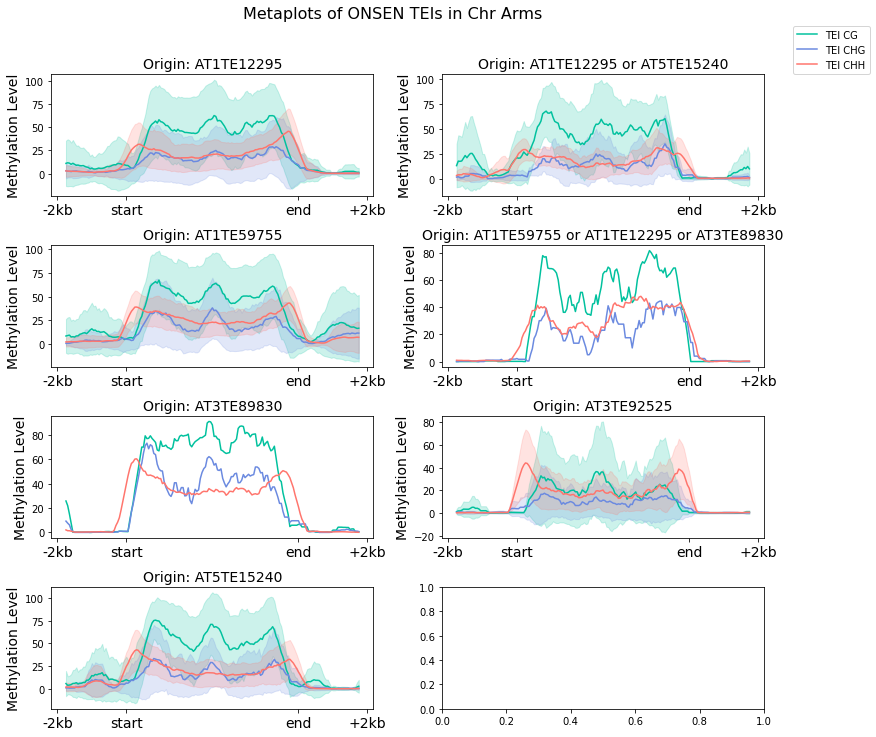

In [ ]:
# Define the contexts
contexts = ['CG', 'CHG', 'CHH']
samples_tei = ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']
samples_onsen = ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']

# Extract ONSEN names
onsen_names = onsen_bins[f'{samples_onsen[0]}_{contexts[0]}']['ONSEN'].unique()

# Initialize dictionaries to store combined data
combined_onsen = {context: [] for context in contexts}
combined_tei = {context: [] for context in contexts}

# Combine TEI data (bins + flanks)
for context in contexts:
    for key in samples_tei:
        tei_selected = tei_ori[tei_ori['sample'] == f'{key}_{context}'][tei_ori[tei_ori['sample'] == f'{key}_{context}']['cen_pos']=='Arm']
        bins = tei_bins[f'{key}_{context}'][tei_bins[f'{key}_{context}']['TEI'].isin(tei_selected['insertion'].to_list())]
        flanks = tei_flanks[f'{key}_{context}'][tei_flanks[f'{key}_{context}']['insertion'].isin(tei_selected['insertion'].to_list())].iloc[:, :81]
        
        flanks.columns = [f'flank_{i}' for i in range(1, 81)]+['TEI']
        bins.columns = ['TEI']+[f'bin_{i}' for i in range(1, len(bins.columns))]

        combined = pd.merge(flanks, bins, on='TEI')
        combined = pd.merge(combined, tei_selected[['insertion', 'origin']], right_on='insertion', left_on='TEI') 
        combined = combined[['origin']+[f'flank_{i}' for i in range(1, 41)]+ [f'bin_{i}' for i in range(1, len(bins.columns))]+ [f'flank_{i}' for i in range(41, 81)]]
        
        
        combined_tei[context].append(combined)
    
    combined_tei[context] = pd.concat(combined_tei[context])


mean_tei = {
    context: combined_tei[context].groupby('origin').mean().reset_index()
    for context in contexts
}
std_tei = {
    context: combined_tei[context].groupby('origin').std().reset_index()
    for context in contexts
}

# Smooth the data
window_size = 10


smoothed_mean_tei = {
    context: mean_tei[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}
smoothed_std_tei = {
    context: std_tei[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}

# Define colors and alpha for std
context_colors = {'CG': '#01c19e', 'CHG': '#6b8ae0', 'CHH': '#ff756d'}
alpha = 0.2  # Transparency for std shading

# Create the metaplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(11, 10))
axes = axes.flatten()
fig.suptitle('Metaplots of ONSEN TEIs in Chr Arms', fontsize=16, y=1.02)

# Create legend handles
handles, labels = [], []

# Plot ONSEN and TEI metaplots for each ONSEN
for i, onsen_name in enumerate(mean_tei[contexts[0]]['origin'].unique()):
    ax = axes[i]

    
    #Plot TEI methylation with std (if TEIs exist)
    if onsen_name in mean_tei[contexts[0]]['origin'].unique():
        for context in contexts:
            # Get mean and std
            mean = smoothed_mean_tei[context][mean_tei[context]['origin'] == onsen_name].values.flatten()
            std = smoothed_std_tei[context][std_tei[context]['origin'] == onsen_name].values.flatten()
            
            # Plot mean line
            line, = ax.plot(mean, label=f'{context}', color=context_colors[context], linestyle='-')
            
            # Plot std shading
            ax.fill_between(range(len(mean)), mean - std, mean + std, 
                            color=context_colors[context], alpha=alpha)
            
            if i == 0:  # Add to legend only once
                handles.append(line)
                labels.append(f'{context}')
    
    # Customize the plot
    ax.set_title(f'Origin: {onsen_name}', fontsize=14)
    ax.set_ylabel('Methylation Level (%)', fontsize=13)
    ax.grid(False)
    ax.set_xticks([0, 40, 140, 180])
    ax.set_xticklabels(['-2kb', 'start', 'end', '+2kb'], fontsize=14)

# Add a single legend for the whole figure
fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.savefig('plots/metaplots_tei_with_std_arm.svg', bbox_inches='tight', dpi=300)


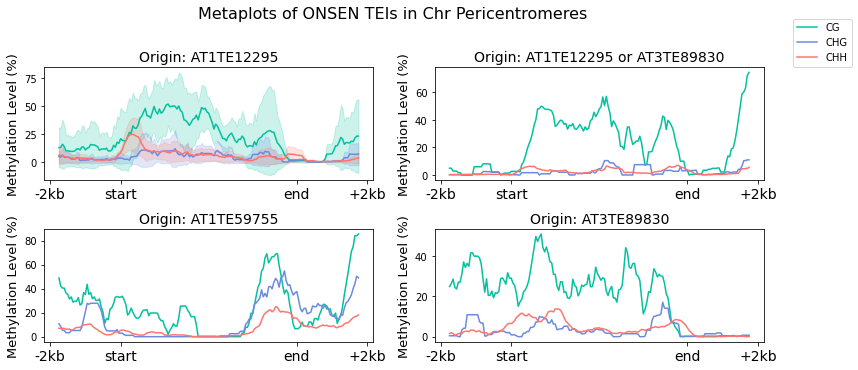

In [49]:
# Define the contexts
contexts = ['CG', 'CHG', 'CHH']
samples_tei = ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']
samples_onsen = ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']

# Extract ONSEN names
onsen_names = onsen_bins[f'{samples_onsen[0]}_{contexts[0]}']['ONSEN'].unique()

# Initialize dictionaries to store combined data
combined_onsen = {context: [] for context in contexts}
combined_tei = {context: [] for context in contexts}

# Combine TEI data (bins + flanks)
for context in contexts:
    for key in samples_tei:
        tei_selected = tei_ori[tei_ori['sample'] == f'{key}_{context}'][tei_ori[tei_ori['sample'] == f'{key}_{context}']['cen_pos']=='Pericentromere']
        bins = tei_bins[f'{key}_{context}'][tei_bins[f'{key}_{context}']['TEI'].isin(tei_selected['insertion'].to_list())]
        flanks = tei_flanks[f'{key}_{context}'][tei_flanks[f'{key}_{context}']['insertion'].isin(tei_selected['insertion'].to_list())].iloc[:, :81]
        
        flanks.columns = [f'flank_{i}' for i in range(1, 81)]+['TEI']
        bins.columns = ['TEI']+[f'bin_{i}' for i in range(1, len(bins.columns))]

        combined = pd.merge(flanks, bins, on='TEI')
        combined = pd.merge(combined, tei_selected[['insertion', 'origin']], right_on='insertion', left_on='TEI') 
        combined = combined[['origin']+[f'flank_{i}' for i in range(1, 41)]+ [f'bin_{i}' for i in range(1, len(bins.columns))]+ [f'flank_{i}' for i in range(41, 81)]]
        
        combined_tei[context].append(combined)
    
    combined_tei[context] = pd.concat(combined_tei[context])

mean_tei = {
    context: combined_tei[context].groupby('origin').mean().reset_index()
    for context in contexts
}
std_tei = {
    context: combined_tei[context].groupby('origin').std().reset_index()
    for context in contexts
}

# Smooth the data
window_size = 10


smoothed_mean_tei = {
    context: mean_tei[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}
smoothed_std_tei = {
    context: std_tei[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}

# Define colors and alpha for std
context_colors = {'CG': '#01c19e', 'CHG': '#6b8ae0', 'CHH': '#ff756d'}
alpha = 0.2  # Transparency for std shading

# Create the metaplots
fig, axes = plt.subplots(nrows=int(len(mean_tei[contexts[0]]['origin'].unique()) / 2), ncols=2, figsize=(11, 5))
axes = axes.flatten()
fig.suptitle('Metaplots of ONSEN TEIs in Chr Pericentromeres', fontsize=16, y=1.02)

# Create legend handles
handles, labels = [], []

# Plot ONSEN and TEI metaplots for each ONSEN
for i, onsen_name in enumerate(mean_tei[contexts[0]]['origin'].unique()):
    ax = axes[i]

    
    #Plot TEI methylation with std (if TEIs exist)
    if onsen_name in mean_tei[contexts[0]]['origin'].unique():
        for context in contexts:
            # Get mean and std
            mean = smoothed_mean_tei[context][mean_tei[context]['origin'] == onsen_name].values.flatten()
            std = smoothed_std_tei[context][std_tei[context]['origin'] == onsen_name].values.flatten()
            
            # Plot mean line
            line, = ax.plot(mean, label=f'{context}', color=context_colors[context], linestyle='-')
            
            # Plot std shading
            ax.fill_between(range(len(mean)), mean - std, mean + std, 
                            color=context_colors[context], alpha=alpha)
            
            if i == 0:  # Add to legend only once
                handles.append(line)
                labels.append(f'{context}')
    
    # Customize the plot
    ax.set_title(f'Origin: {onsen_name}', fontsize=14)
    ax.set_ylabel('Methylation Level (%)', fontsize=13)
    ax.grid(False)
    ax.set_xticks([0, 40, 140, 180])
    ax.set_xticklabels(['-2kb', 'start', 'end', '+2kb'], fontsize=14)

# Add a single legend for the whole figure
fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.savefig('plots/metaplots_tei_with_std_cen.svg', bbox_inches='tight', dpi=300)


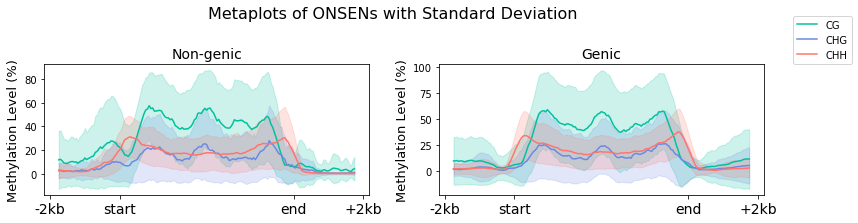

In [50]:
# Define the contexts
contexts = ['CG', 'CHG', 'CHH']
samples_tei = ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']
samples_onsen = ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']

# Extract ONSEN names
# onsen_names = onsen_bins[f'{samples_onsen[0]}_{contexts[0]}']['ONSEN'].unique()

# Initialize dictionaries to store combined data
combined_onsen = {context: [] for context in contexts}
combined_tei = {context: [] for context in contexts}

# Combine ONSEN data (bins + flanks)

# Combine TEI data (bins + flanks)
for context in contexts:
    for key in samples_tei:
        bins = tei_bins[f'{key}_{context}']
        flanks = tei_flanks[f'{key}_{context}'].iloc[:, :81]
        
        flanks.columns = [f'flank_{i}' for i in range(1, 81)]+['TEI']
        bins.columns = ['TEI']+[f'bin_{i}' for i in range(1, len(bins.columns))]

        combined = pd.merge(flanks, bins, on='TEI')
        combined = pd.merge(combined, tei_ori[tei_ori['sample'] == f'{key}_{context}'][['insertion', 'genic']], right_on='insertion', left_on='TEI') 
        combined = combined[['genic']+[f'flank_{i}' for i in range(1, 41)]+ [f'bin_{i}' for i in range(1, len(bins.columns))]+ [f'flank_{i}' for i in range(41, 81)]]
        
        combined_tei[context].append(combined)
    
    combined_tei[context] = pd.concat(combined_tei[context])


mean_tei = {
    context: combined_tei[context].groupby('genic').mean().reset_index()
    for context in contexts
}
std_tei = {
    context: combined_tei[context].groupby('genic').std().reset_index()
    for context in contexts
}

# Smooth the data

smoothed_mean_tei = {
    context: mean_tei[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}
smoothed_std_tei = {
    context: std_tei[context].iloc[:, 1:].rolling(window=window_size, axis=1, center=True).mean()
    for context in contexts
}

# Define colors and alpha for std
ccontext_colors = {'CG': '#01c19e', 'CHG': '#6b8ae0', 'CHH': '#ff756d'}
alpha = 0.2  # Transparency for std shading

# Create the metaplots
fig, axes = plt.subplots(nrows=int(len(mean_tei[contexts[0]]['genic'].unique()) / 2), ncols=2, figsize=(11, 3))
axes = axes.flatten()
fig.suptitle('Metaplots of ONSENs with Standard Deviation', fontsize=16, y=1.02)

# Create legend handles
handles, labels = [], []

# Plot ONSEN and TEI metaplots for each ONSEN
for i, onsen_name in enumerate(mean_tei[contexts[0]]['genic'].unique()):
    ax = axes[i]
    
    
    #Plot TEI methylation with std (if TEIs exist)
    if onsen_name in mean_tei[contexts[0]]['genic'].unique():
        for context in contexts:
            # Get mean and std
            mean = smoothed_mean_tei[context][mean_tei[context]['genic'] == onsen_name].values.flatten()
            std = smoothed_std_tei[context][std_tei[context]['genic'] == onsen_name].values.flatten()
            
            # Plot mean line
            line, = ax.plot(mean, label=f'TEI {context}', color=context_colors[context], linestyle='-')
            
            # Plot std shading
            ax.fill_between(range(len(mean)), mean - std, mean + std, 
                            color=context_colors[context], alpha=alpha)
            
            if i == 0:  # Add to legend only once
                handles.append(line)
                labels.append(f'{context}')
    
    # Customize the plot
    ax.set_title(['Non-genic', 'Genic'][i], fontsize=14)
    ax.set_ylabel('Methylation Level (%)', fontsize=13)
    ax.grid(False)
    ax.set_xticks([0, 40, 140, 180])
    ax.set_xticklabels(['-2kb', 'start', 'end', '+2kb'], fontsize=14)

# Add a single legend for the whole figure
fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(1.00, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.savefig('plots/metaplots_tei_by_genic_with_std.svg', bbox_inches='tight', dpi=300)


/home/alatypova/mobivision-v3.2/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/alatypova/mobivision-v3.2/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/alatypova/mobivision-v3.2/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/alatypova/mobivision-v3.2/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/alatypova/mobivision-v3.2/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/alatypova/mobivision-v3.2/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered 

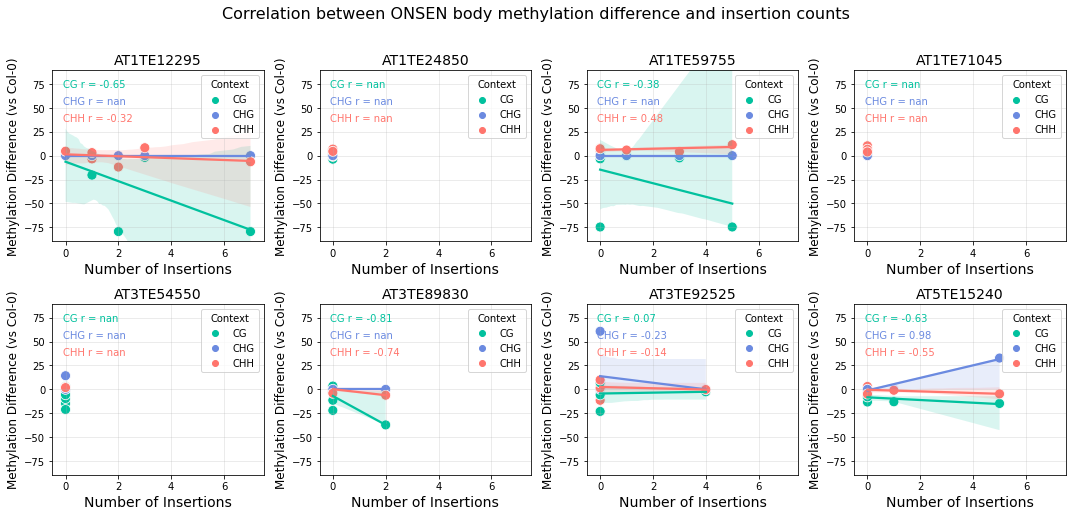

In [70]:
# Define contexts and samples
contexts = ['CG', 'CHG', 'CHH']
samples = ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']
ref_sample = 'Col-0'  # Reference sample
NUM_BINS = 100

# 1. Calculate mean methylation in ONSEN bodies and differences from Col-0
onsen_meth_diff = {}

# Get all ONSEN names from the reference sample
onsen_names = onsen_bins[f'{ref_sample}_{contexts[0]}']['ONSEN'].unique()

for context in contexts:
    # Get reference (Col-0) methylation for this context
    ref_meth = onsen_bins[f'{ref_sample}_{context}'].groupby('ONSEN').mean().iloc[:, :NUM_BINS].median(axis=1)
    
    # Calculate methylation differences for each sample
    for sample in samples:
        sample_meth = onsen_bins[f'{sample}_{context}'].groupby('ONSEN').mean().iloc[:, :NUM_BINS].median(axis=1)
        diff = sample_meth - ref_meth
        
        # Store results
        for onsen in onsen_names:
            if onsen not in onsen_meth_diff:
                onsen_meth_diff[onsen] = {context: {} for context in contexts}
            onsen_meth_diff[onsen][context][sample] = diff[onsen]

# 2. Count insertions originating from each ONSEN in each sample
insertion_counts = {onsen: {sample: 0 for sample in samples} for onsen in onsen_names}

# Process lookup dataframe to count insertions
for _, row in lookup.iterrows():
    sample = row['sample'].split('_')[0]  # Remove '_CHH' suffix
    origin = row['origin']
    if sample in samples and origin in onsen_names:
        insertion_counts[origin][sample] += 1

# 3. Create the correlation plots
fig, axes = plt.subplots(2, 4, figsize=(15, 7))
fig.suptitle('Correlation between ONSEN body methylation difference and insertion counts', y=1.02, fontsize=16)
axes = axes.flatten()

# Define colors
context_colors = {'CG': '#01c19e', 'CHG': '#6b8ae0', 'CHH': '#ff756d'}

# Create one plot per ONSEN
for i, onsen in enumerate(onsen_names):
    ax = axes[i]
    
    # Prepare data for plotting
    plot_data = []
    for sample in samples:
        for context in contexts:
            plot_data.append({
                'Sample': sample,
                'Context': context,
                'Methylation Difference': onsen_meth_diff[onsen][context][sample],
                'Insertion Count': insertion_counts[onsen][sample]
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create scatter plot with regression lines
    sns.scatterplot(data=plot_df, x='Insertion Count', y='Methylation Difference', 
                    hue='Context', palette=context_colors, ax=ax, s=100)
    
    # Add regression lines
    for context in contexts:
        context_df = plot_df[plot_df['Context'] == context]
        sns.regplot(data=context_df, x='Insertion Count', y='Methylation Difference',
                    scatter=False, color=context_colors[context], ax=ax)
    
    # Calculate and display correlation coefficients
    for context in contexts:
        context_df = plot_df[plot_df['Context'] == context]
        r = np.corrcoef(context_df['Insertion Count'], context_df['Methylation Difference'])[0, 1]
        ax.text(0.05, 0.9 - 0.1*list(contexts).index(context), 
                f'{context} r = {r:.2f}', 
                transform=ax.transAxes, color=context_colors[context])
    
    ax.set_title(onsen, fontsize=14)
    ax.set_xlabel('Number of Insertions', fontsize=14)
    ax.set_ylabel('Methylation Difference (vs Col-0)', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Set consistent x and y limits for better comparison
    ax.set_xlim(-0.5, max([insertion_counts[o][s] for o in onsen_names for s in samples]) + 0.5)
    max_diff = max([abs(onsen_meth_diff[o][c][s]) for o in onsen_names for c in contexts for s in samples])
    ax.set_ylim(-max_diff - 10, max_diff + 10)

# Remove empty subplots if we have less than 8 ONSENs
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('plots/onsen_insertion_correlation_median.svg', bbox_inches='tight', dpi=300)


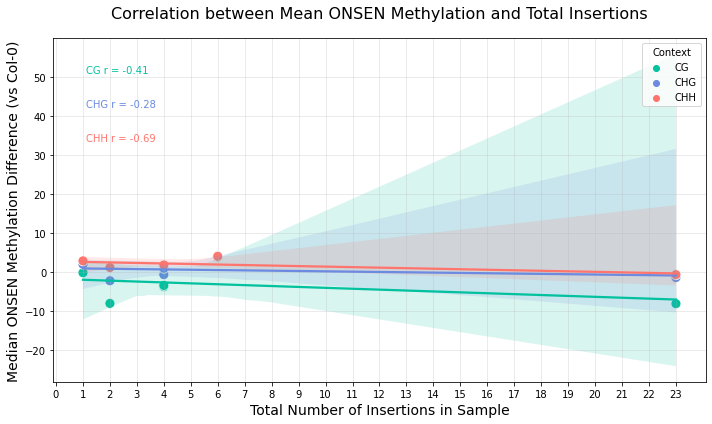

In [71]:
# Define contexts and samples
contexts = ['CG', 'CHG', 'CHH']
samples = ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']
ref_sample = 'Col-0'  # Reference sample

# 1. Calculate mean methylation across all ONSENs and differences from Col-0
sample_meth_diff = {context: {} for context in contexts}

for context in contexts:
    # Get reference (Col-0) methylation for this context
    ref_meth = onsen_bins[f'{ref_sample}_{context}'].groupby('ONSEN').mean().iloc[:, :NUM_BINS].mean(axis=1).mean()
    
    # Calculate mean methylation differences for each sample
    for sample in samples:
        sample_mean_meth = onsen_bins[f'{sample}_{context}'].groupby('ONSEN').mean().iloc[:, :NUM_BINS].mean(axis=1).mean()
        sample_meth_diff[context][sample] = sample_mean_meth - ref_meth

# 2. Count total insertions per sample (from all ONSENs)
total_insertions = {sample: 0 for sample in samples}

# Process lookup dataframe to count all insertions per sample
for _, row in lookup.iterrows():
    sample = row['sample'].split('_')[0]  # Remove '_CHH' suffix
    if sample in samples:
        total_insertions[sample] += 1

# 3. Prepare data for plotting
plot_data = []
for sample in samples:
    for context in contexts:
        plot_data.append({
            'Sample': sample,
            'Context': context,
            'Mean Methylation Difference': sample_meth_diff[context][sample],
            'Total Insertions': total_insertions[sample]
        })

plot_df = pd.DataFrame(plot_data)

# 4. Create the combined plot
plt.figure(figsize=(10, 6))

# Define colors
context_colors = {'CG': '#01c19e', 'CHG': '#6b8ae0', 'CHH': '#ff756d'}

# Create scatter plot with regression lines
sns.scatterplot(data=plot_df, x='Total Insertions', y='Mean Methylation Difference', 
                hue='Context', palette=context_colors, s=100)

# Add regression lines
for context in contexts:
    context_df = plot_df[plot_df['Context'] == context]
    sns.regplot(data=context_df, x='Total Insertions', y='Mean Methylation Difference',
                scatter=False, color=context_colors[context])

# Calculate and display correlation coefficients
for context in contexts:
    context_df = plot_df[plot_df['Context'] == context]
    r = np.corrcoef(context_df['Total Insertions'], context_df['Mean Methylation Difference'])[0, 1]
    plt.text(0.05, 0.9 - 0.1*list(contexts).index(context), 
             f'{context} r = {r:.2f}', 
             transform=plt.gca().transAxes, color=context_colors[context])

plt.title('Correlation between Mean ONSEN Methylation and Total Insertions', pad=20, fontsize=16)
plt.xlabel('Total Number of Insertions in Sample', fontsize=14)
plt.ylabel('Median ONSEN Methylation Difference (vs Col-0)', fontsize=14)
plt.grid(True, alpha=0.3)

# Adjust x-axis to show whole numbers only
max_insertions = max(total_insertions.values())
plt.xticks(range(0, max_insertions + 1))

plt.tight_layout()
plt.savefig('plots/mean_onsen_insertion_correlation_median.svg', bbox_inches='tight', dpi=300)


/tmp/ipykernel_80157/877136124.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_meth = mean_meth[mean_meth['ONSEN'] == onsen].iloc[:, :NUM_BINS].mean(axis=1).values[0]


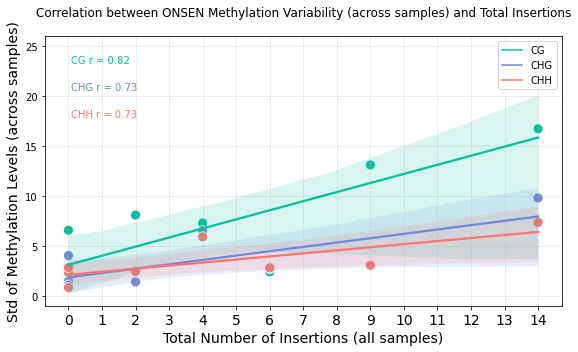

In [ ]:
# Define contexts and samples
contexts = ['CG', 'CHG', 'CHH']
all_samples = ['Col-0', '12-1', '1-1', '3-6', '7-5', '13-1', '14-2']
samples_with_insertions = ['12-1', '1-1', '3-6', '7-5', '13-1', '14-2']

# Get all ONSEN names
onsen_names = onsen_bins[f'Col-0_{contexts[0]}']['ONSEN'].unique()

# 1. Calculate methylation std across samples for each ONSEN
onsen_meth_std = {context: {} for context in contexts}
total_insertions = {}

# First collect all methylation values
for context in contexts:
    for onsen in onsen_names:
        # Get methylation values across all samples for this ONSEN
        meth_values = []
        for sample in all_samples:
            # Get mean methylation across bins for this sample
            mean_meth = onsen_bins[f'{sample}_{context}']
            mean_meth = mean_meth[mean_meth['ONSEN'] == onsen].iloc[:, :NUM_BINS].mean(axis=1).values[0]
            meth_values.append(mean_meth)
        
        # Calculate std across samples
        onsen_meth_std[context][onsen] = np.std(meth_values)

# 2. Count total insertions per ONSEN (across all samples)
for onsen in onsen_names:
    total_insertions[onsen] = 0
    for _, row in lookup.iterrows():
        if row['origin'] == onsen and row['sample'].split('_')[0] in samples_with_insertions:
            total_insertions[onsen] += 1

# 3. Prepare data for plotting
plot_data = []
for onsen in onsen_names:
    for context in contexts:
        plot_data.append({
            'ONSEN': onsen,
            'Context': context,
            'Methylation Std (across samples)': onsen_meth_std[context][onsen],
            'Total Insertions': total_insertions[onsen]
        })

plot_df = pd.DataFrame(plot_data)

# 4. Create the plot
plt.figure(figsize=(8, 5))

# Define colors
context_colors = {'CG': '#01c19e', 'CHG': '#6b8ae0', 'CHH': '#ff756d'}

# Create scatter plot with regression lines
sns.scatterplot(data=plot_df, x='Total Insertions', y='Methylation Std (across samples)', 
                hue='Context', palette=context_colors, s=100)

# Add regression lines
for context in contexts:
    context_df = plot_df[plot_df['Context'] == context]
    sns.regplot(data=context_df, x='Total Insertions', y='Methylation Std (across samples)',
                scatter=False, color=context_colors[context])

# Calculate and display correlation coefficients
for context in contexts:
    context_df = plot_df[plot_df['Context'] == context]
    r = np.corrcoef(context_df['Total Insertions'], context_df['Methylation Std (across samples)'])[0, 1]
    plt.text(0.05, 0.9 - 0.1*list(contexts).index(context), 
             f'{context} r = {r:.2f}', 
             transform=plt.gca().transAxes, color=context_colors[context])

plt.title('Correlation between ONSEN Methylation Variability (across samples) and Total Insertions', pad=20)
plt.xlabel('Total Number of Insertions (all samples)', fontsize=14)
plt.ylabel('Std of Methylation Levels (across samples)', fontsize=14)
plt.grid(True, alpha=0.3)

# Adjust x-axis to show whole numbers only
max_insertions = max(total_insertions.values())
plt.xticks(range(0, max_insertions + 1), fontsize=14)
plt.ylim( - 1, 26)

plt.legend(handles, labels, fontsize=10, bbox_to_anchor=(1, 1), loc='upper right')


plt.tight_layout()
plt.savefig('plots/onsen_std_across_samples_vs_insertions.png', bbox_inches='tight', dpi=300)